# Classification Tasks with Kinematic Time Series from Head Pose Estimation from HMD

## 1. Dataset
- Tsinghua: Preprocessed structured dataset from paper [here](https://wuchlei-thu.github.io/)

## 2. Data Representations
- Quaternion (4D)
- Euler Rotation (3D)
- Yaw Rotation (1D)

## 3. Feature Extraction 1/2
- Raw time-series
- Velocity
- Acceleration

## 4. Feature Extraction 2/2
- Summary statistics
    - Maximum
    - Minimum
    - Average
    - Standard deviation
    - Median

## 5. Classifier
- Feature-based classifiers
    - 1-NN + DTW
- Time-series classifiers (their input is directly the time series from **Data representations**)
    - STSF
    - ROCKET

## Evaluation
- Each classifier is evaluated by comparing the accuracy over Monte Carlo simulations.

In [54]:
# Add files to sys.path
from pathlib import Path
import sys,os
this_path = None
try:
    this_path = str(os.path.dirname(os.path.abspath(__file__))) #str(Path().absolute())+"/" # str(os.path.dirname(__file__))
except:
    this_path = str(Path().absolute())+"/" #str(Path().absolute())+"/" # str(os.path.dirname(__file__))
print("File Path:", this_path)
sys.path.append(os.path.join(this_path, "kinemats"))

# Import classes
import utils  # Utils for generation of files and paths
import quaternion_math

from plotter.ts_visualization import *
import ts_processing
import ts_classification

# Import data science libs
import numpy as np
import pandas as pd

import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#%matplotlib inline
import matplotlib.pyplot as plt

File Path: C:\Users\darksoul\Downloads\head-motion-classification-AIVR21-/


---
# SETUP

In [55]:
# CONSTANTS
import experiment_config
from experiment_config import Datasets, DataRepresentation, Classifiers
from ts_classification import EnumDistMetrics

# All the files generated from this notebook are in a subfolder with this name
NOTEBOOK_SUBFOLDER_NAME = '1_DataRep_DistMetrics/'

# Filenames of created files from this script
FILENAME_DATASET_QUATERNION = str(experiment_config.PREFIX_DATASET+str(DataRepresentation.Quaternion))      # generates "dataset_quaternion"
FILENAME_DATASET_EULER = str(experiment_config.PREFIX_DATASET+str(DataRepresentation.Euler))
# FILENAME_DATASET_SPHERICAL = str(experiment_config.PREFIX_DATASET+str(DataRepresentation.Spherical))
FILENAME_DATASET_YAW = str(experiment_config.PREFIX_DATASET+str(DataRepresentation.Yaw))

#### NOTE: This dictionary is reassigned later in the code whenever the datasets are generated.
DICT_DATA_REPRESENTATIONS = {
    DataRepresentation.Quaternion:  None,
    DataRepresentation.Euler:       None,
    # DataRepresentation.Spherical:   None,
    DataRepresentation.Yaw:         None,
}

# Dictionary to convert a datarepresentation into a num - To be stored in the numpy array for results
DICT_DATAREP_TO_NUM = { k:i for i,k in enumerate(DICT_DATA_REPRESENTATIONS.keys())}

# Distance metrics that are applied to do cross-similarity matrices for each dataset
DICT_DIST_METRICS = {
    # Without clamping distance values
    # "euclidean":        EnumDistMetrics.Euclidean,                 # Standard Euclidean L2-norm
    # Specific Clamped Euclidean (Different for euler and quaternions) # First has to be for quaternions
    # "euclid_specif":    [EnumDistMetrics.EuclideanClamped_Quat, EnumDistMetrics.EuclideanClamped_EulerAngle], 
    # DTW per dimension, then adds them together
    "dtw":              EnumDistMetrics.DtwSumMultiDim
}
# Dictionary to convert a distance metric into a num - To be stored in the numpy array for results
DICT_DISTMETRIC_TO_NUM = { k:i for i,k in enumerate(DICT_DIST_METRICS.keys())}

# Classification methods to apply
LIST_CLASSIFIERS = [Classifiers.KNN_1]

# elif experiment_config.DATASET_MAIN == Datasets.Tsinghua:
    # LIST_CLASSIFIERS.append(Classifiers.KNN_11)

# How many iterations to conduct the steps: [training-testing-classification]
MC_ITERATIONS = experiment_config.MC_ITERATIONS

In [56]:
# COMBINATIONS FOR CROSS-SIMILARITY MATRICES
# Every data representation is going to be assessed with each type of metric
# for the case where the metric is a list, it specifies whether it is for quaternion or other data rep.
combinations_to_analyze = []
for dr, datarep in enumerate(DICT_DATA_REPRESENTATIONS.keys()):
    for m,metric in enumerate(DICT_DIST_METRICS.keys()):
        comb = (datarep,metric) 
        combinations_to_analyze.append( comb )
        print(comb)

(<DataRepresentation.Quaternion: 'quaternion'>, 'dtw')
(<DataRepresentation.Euler: 'euler'>, 'dtw')
(<DataRepresentation.Yaw: 'yaw'>, 'dtw')


---
# UTILITY FUNCTIONS

Generate paths to write output files

In [57]:
STR_DATASET = str(experiment_config.DATASET_MAIN)+"/"
print(STR_DATASET)
def gen_path_plot(filename):
    # Generates full paths for PLOTS just by specifying a name
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.PLOT_FOLDER, \
                                        subfolders=STR_DATASET+NOTEBOOK_SUBFOLDER_NAME, \
                                        file_extension=experiment_config.IMG_FORMAT, save_files=experiment_config.EXPORT_PLOTS)

def gen_path_temp(filename, subfolders="", extension=experiment_config.TEMP_FORMAT):
    # Generates full paths for TEMP FILES just by specifying a name
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.TEMP_FOLDER, \
                                        subfolders=STR_DATASET+subfolders, \
                                        file_extension=extension)

def gen_path_results(filename, subfolders="", extension=""):
    # Generates full paths for RESULTS FILES (like pandas dataframes)
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.RESULTS_FOLDER, \
                                        subfolders=STR_DATASET+NOTEBOOK_SUBFOLDER_NAME+subfolders, \
                                        file_extension=extension)

Tsinghua/


# DATASETS: Load and preprocess

Datasets are adapted to have the reference right-hand coordinate system used: front=1, left=j, up=k

In [58]:
print("\t>>>LOADING DATASETS")
dataset = None
classes = None

# Coordinate reference system. All datasets should be transformed to match this coordinate system.
AXIS_FRONT=1
AXIS_LEFT=2
AXIS_UP=3

# Quaternion representation. All datasets should be transformed to match this quaternion representation.
# [qw, qi, qj qk]

	>>>LOADING DATASETS


## Load Dataset Tsinghua

In [59]:
if experiment_config.DATASET_MAIN == Datasets.Tsinghua:
        
    # Data for combined time series to cluster
    labels_filename = experiment_config.DATASET_LABELS # Cluster index TRUE_LABEL
    timestamps_filename = experiment_config.DATASET_TIMESTAMPS # Timestamps
    dataset_filename = experiment_config.DATASET_DATA # Resampled data stats

    labels = pd.read_csv(labels_filename)
    timestamps = np.loadtxt(timestamps_filename)
    dataset = utils.load_binaryfile_npy(dataset_filename)

    dataset = np.clip(dataset, -1, 1)

    ## QUATERNION REPRESENTATION
    # originally [qi, qj, qk, qw] --> Change to [qw,qi,qj,qk]
    dataset_copy = dataset.copy()
    dataset[...,0] = dataset_copy[...,3]
    dataset[...,1] = dataset_copy[...,0]
    dataset[...,2] = dataset_copy[...,1]
    dataset[...,3] = dataset_copy[...,2]

    ## COORDINATE SYSTEM: Unity is left-handed (right, up, front), needs to be converted to right-handed (front, left, up)
    dataset_copy = dataset.copy()
    dataset[...,1] = dataset_copy[...,3]     # Change FRONT to first position
    dataset[...,2] = -1*dataset_copy[...,1]  # Change RIGHT to second position with opposite orientation in the coordinate system to make it LEFT
    dataset[...,3] = dataset_copy[...,2]     # Change UP from second to third position

    # Classes are the labels of the videos 
    classes = labels["videoId"].to_numpy(dtype=np.int32)
    ## Classes are the user watching the videos
    #classes = labels["user"].to_numpy(dtype=np.int32)

### How to access the dataset

- `timestamps` is a ndarray that contains the value of the time axis of the time series (in seconds).
- `classes` is a numpy array that contains the labels of the 290 time series.
- `dataset` is a ndarray of  3 dimensions as follows: `[`time series index (mapped to labels `id`), time series values, quaterion values (q0, qi, qj, qk)`]`

## Summary dataset

In [60]:
num_classes = np.unique(classes).size

if(dataset.ndim == 2):
    dataset = np.expand_dims(dataset, axis=2)

num_ts = dataset.shape[0]
length_ts = dataset.shape[1]
num_dims = dataset.shape[2]

print("Timestamps:", type(timestamps), timestamps.shape)
print("Dataset", type(dataset), dataset.shape)
print("Classes", type(classes), classes.shape)
print(f"num_classes={num_classes}")
print(f"num_ts={num_ts}")
print(f"length_ts={length_ts}")
print(f"num_dims={num_dims}")

Timestamps: <class 'numpy.ndarray'> (3601,)
Dataset <class 'numpy.ndarray'> (432, 3601, 4)
Classes <class 'numpy.ndarray'> (432,)
num_classes=9
num_ts=432
length_ts=3601
num_dims=4


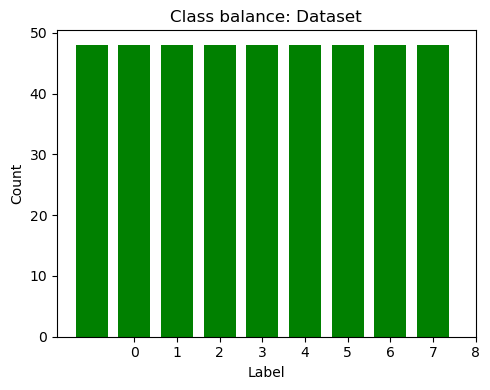

In [61]:
if(experiment_config.SHOW_PLOTS): plot_histogram_class_balance([pd.Series(classes)], plot_titles = ["Dataset"], figsize=(5,4), save_path=gen_path_plot("class_balance"))

In [62]:
# 2% rolling window
ROLLING_WINDOW_PLOT = int(length_ts*0.02) 
print(f"ROLLING_WINDOW_PLOT={ROLLING_WINDOW_PLOT}")

ROLLING_WINDOW_PLOT=72


# Data Representation (Time-Series Representation)

One of the main problems with the use of rotations in ML is that they are discontinuous in the Euclidean space of four or fewer dimensions. But they have continuous representations in 5D and 6D (Exponential Maps). Reference: https://arxiv.org/abs/1812.07035

## 1. Quaternion
In the dataset, the head movemente are stored as quaternions following the structure: **(timestamp, q0, qi, qj, qk)**

In [63]:
print("\t>>>LOADING/CREATING QUATERNION DATA")
# Data for combined time series to cluster
dataset_quaternion_filename = gen_path_temp( FILENAME_DATASET_QUATERNION ) # Quaternion dataset

# Load or create dataframe with statistics of initial dataset (58 users, 5 videos)
dataset_quaternion = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [dataset_quaternion_filename]

# Try to load files maximum two times
for tries in range(experiment_config.RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{experiment_config.RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        dataset_quaternion = utils.load_binaryfile_npy(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""

        dataset_quaternion = dataset.copy() # Original dataset is quaternion, just copy it!
        utils.save_binaryfile_npy(dataset_quaternion, input_files[0])

        ### ---- CONTROL RETRIES
        if tries+1 < experiment_config.RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

	>>>LOADING/CREATING QUATERNION DATA
Trying 1/2 to load files: ['./temp/Tsinghua/dataset_quaternion.npy']
File ./temp/Tsinghua/dataset_quaternion.npy was successfully loaded


In [64]:
# Verify the average magnitude of the quaternions.
magnitudes = [np.linalg.norm(dataset_quaternion[traj,values,:]) for traj in range(num_ts) for values in range(length_ts) ]
print("\MaxMin Magnitudes of Quaternions in dataset",np.max(magnitudes),np.min(magnitudes))
# CONCLUSION: ALL QUATERNION ARE VALID SINCE THEY ARE UNIT QUATERNIONS (Error: 4e-7)

# Rotate a 3D vector according to quaternion
print("\nExample of rotation over a vector:")
print(quaternion_math.point_rotation_by_quaternion([1, 0, 0],[0.7071203316249954, 0.0, 0.7071203316249954, 0.0]))
# This quaternion corresponds to a rotation 90-degrees counterclockwise around Y-axis

dataset_quaternion.shape

\MaxMin Magnitudes of Quaternions in dataset 1.0003496735483592 0.999215335158892

Example of rotation over a vector:
[ 0.          0.         -1.00003833]


(432, 3601, 4)

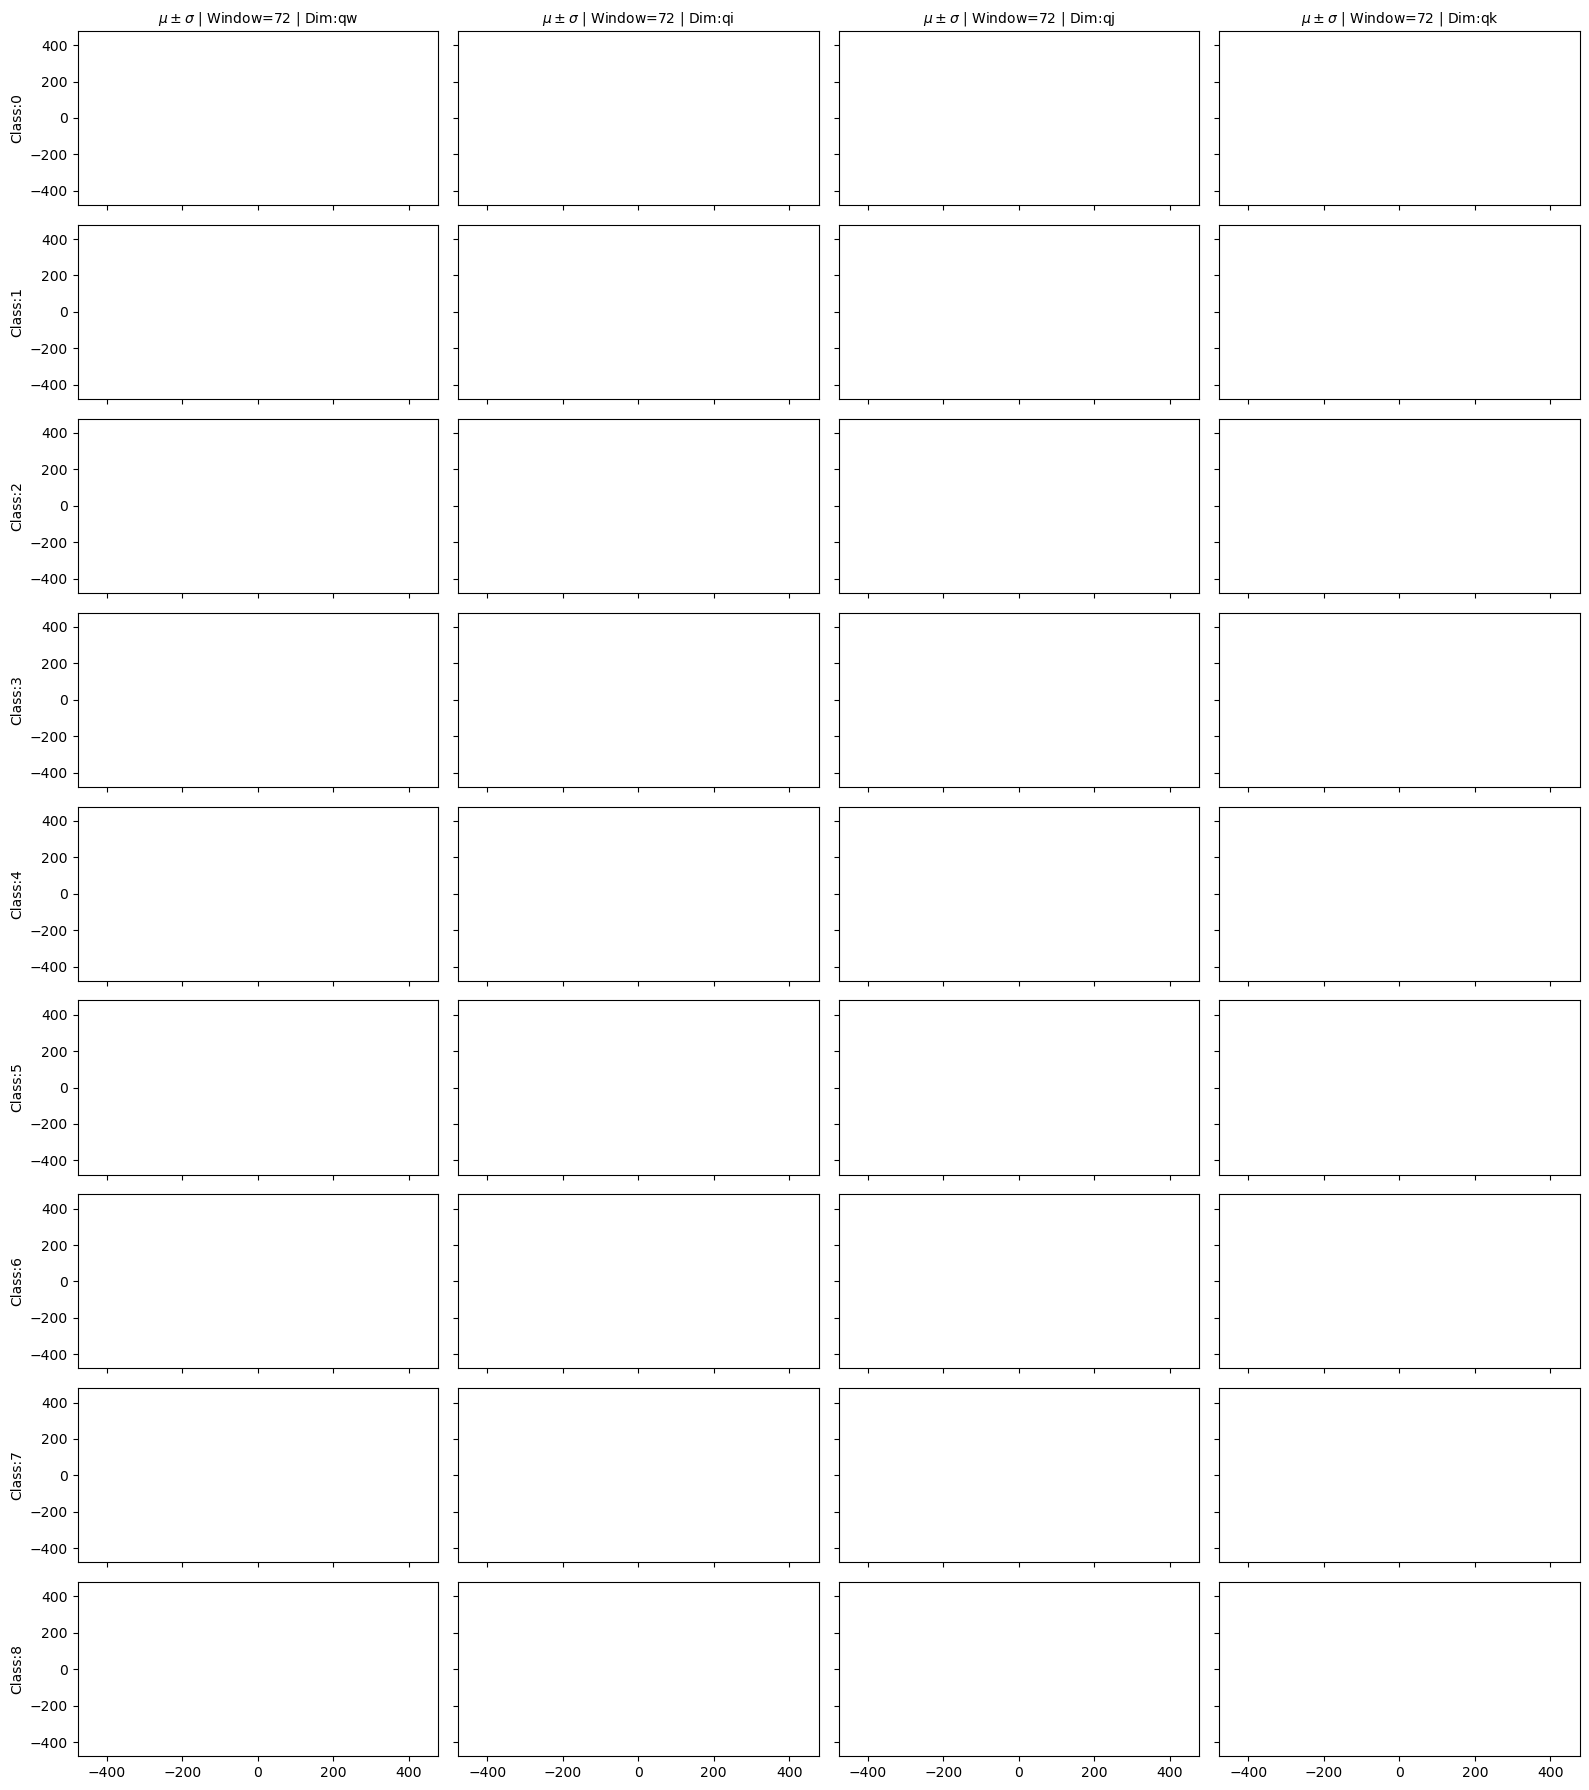

In [65]:
if(experiment_config.SHOW_PLOTS): plot_mean_std_ts(dataset_quaternion, classes, \
                    rolling_window_size=ROLLING_WINDOW_PLOT, \
                    axes_labels=["qw","qi","qj","qk"], \
                    colors=['k','r','g','b'], \
                    figsize=(4,2), \
                    save_path=gen_path_plot("quaternion_summary"))

## 2. Euler Angles

### Converting from Quaternion to Euler Angles (Tait-Bryan Representation)

$ \text{roll}, \quad \phi = \operatorname{atan2} \left(2\left(q_r q_i + q_j q_k\right),1 - 2\left(q_i^2 + q_j^2\right)\right) $

$ \text{pitch}, \quad \theta = \arcsin \left(2\left(q_r q_j - q_k q_i\right)\right)$

$ \text{yaw}, \quad \psi = \operatorname{atan2} \left(2\left(q_r q_k + q_i q_j\right),1 - 2\left(q_j^2 + q_k^2\right)\right)$

There are some singularities when $pitch \approx \pm \pi/2 $

In [66]:
print("\t>>>LOADING/CREATING EULER DATA")
# Data for combined time series to cluster
dataset_euler_filename = gen_path_temp( FILENAME_DATASET_EULER ) # Resampled data stats

# Load or create dataframe with statistics of initial dataset (58 users, 5 videos)
dataset_euler = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [dataset_euler_filename]

# Try to load files maximum two times
for tries in range(experiment_config.RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{experiment_config.RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        dataset_euler = utils.load_binaryfile_npy(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""

        # Axis direction w.r.t Unity coordinate system
        dataset_euler = quaternion_math.quaternion_to_euler(dataset_quaternion, axis_qw=0, axis_front=AXIS_FRONT, axis_left=AXIS_LEFT, axis_up=AXIS_UP)        
        utils.save_binaryfile_npy(dataset_euler, input_files[0])

        ### ---- CONTROL RETRIES
        if tries+1 < experiment_config.RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

	>>>LOADING/CREATING EULER DATA
Trying 1/2 to load files: ['./temp/Tsinghua/dataset_euler.npy']
File ./temp/Tsinghua/dataset_euler.npy was successfully loaded


In [67]:
dataset_euler.shape

(432, 3601, 3)

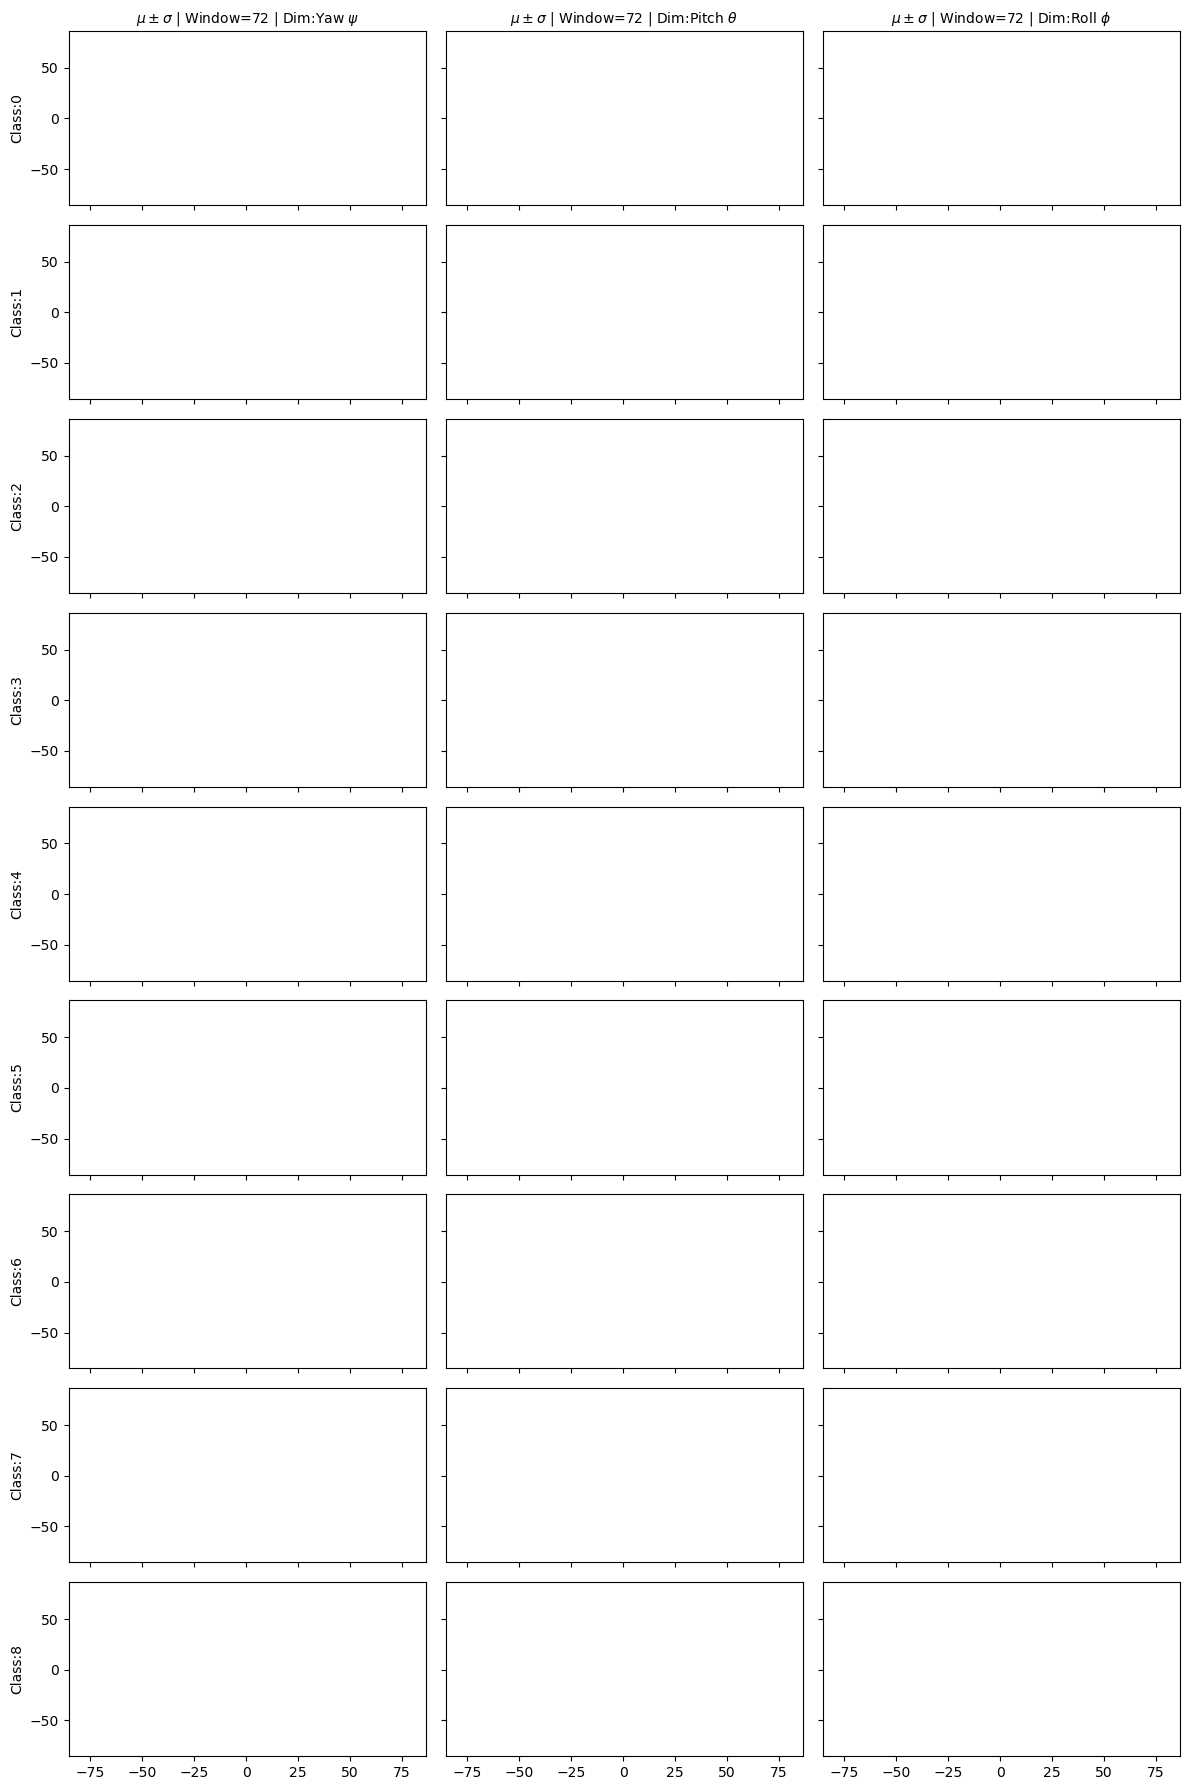

In [68]:
if(experiment_config.SHOW_PLOTS): plot_mean_std_ts(dataset_euler, classes, \
                    rolling_window_size=ROLLING_WINDOW_PLOT, \
                    axes_labels=["Yaw $\psi$","Pitch $\\theta$","Roll $\phi$"], \
                    colors=['r','g','b'], \
                    figsize=(4,2), \
                    save_path=gen_path_plot("euler_summary"))

## 3. Spherical

### Converting from Quaternion to center of viewport in XY-plane

According to the reference frame in the dataset, the coordinate $\hat{i}$ represents the front of the user. Here, we extract the center of the viewport in relation to the orthogonal projection of the 360 video (i.e. unwrapping the sphere into the 2D plane)

Find the resulting vector from the **quaternion rotation operator** of a vector $\mathbf{v}=[1,0,0]$ such as described in the *Section 5.15.1 of the book 1999, Kuipers, Quaternions and Rotation Sequences.*, as: 

$L_q(\mathbf{v})=q\mathbf{v}q*$  Where $\mathbf{v}$ is a vector in $\mathbb{R}^3$ expanded as $\mathbf{v} = (0, v_x, v_y, v_z)$ for the calculation of the quaternion sequence.

After finding the sequence of vectors $ P = [x,y,z] \in \mathbb{R}^3$ that define the trajectory of the viewport. It is converted to spherical coordinates as $\rho$: radial distance, $\theta$: azimuthal angle, $\phi$: polar angle:

$\rho = \sqrt{x^2 + y^2 + z^2}, \quad \rho \in \mathbb{R}^+$, in this case $\rho = 1$ because $v$ is a unit vector and quaternion rotations are around the **unitary** great circle.

$\theta = \arctan{\frac{y}{x}}, \quad \theta \in (-\pi,\pi]$, positive angles indicate rotation CCW (i.e. turning the head to the left) from the center position.

$\phi = \arccos{\frac{z}{\rho}}, \quad \phi \in [0,\pi]$, positive values indicate moving the head down, when user looks exactly forward, the value is $\phi = \pi/2$

![spherical-coordinates](https://mathinsight.org/media/image/image/spherical_coordinates.png)

In [69]:
# print("\t>>>LOADING/CREATING SPHERICAL DATA")
# ## CREATE FILE PICKLE
# # Data for combined time series to cluster
# dataset_spherical_filename = gen_path_temp( FILENAME_DATASET_SPHERICAL ) # Spherical dataset

# # Load or create dataframe with statistics of initial dataset (58 users, 5 videos)
# dataset_spherical = None

# ### INPUTS / OUTPUTS
# """EDIT CUSTOM FILENAMES"""
# input_files = [dataset_spherical_filename]

# # Try to load files maximum two times
# for tries in range(experiment_config.RELOAD_TRIES):
#     try:
#         ### LOAD FILE
#         print(f"Trying {tries+1}/{experiment_config.RELOAD_TRIES} to load files: {input_files}")
        
#         ### CUSTOM SECTION TO READ FILES
#         """EDIT CUSTOM READ"""
#         dataset_spherical = utils.load_binaryfile_npy(input_files[0])
#         print(f"File {input_files[0]} was successfully loaded")

#     except Exception as e:
#         ### CREATE FILE
#         print(f"File not found. Creating again! {e}")

#         ### CUSTOM SECTION TO CREATE FILES 
#         """EDIT CUSTOM WRITE"""

#         # The center of the viewport is the vector `viewport_perp`. Where it lands according to 
#         # rotations at each timepoint is found by `apply_quaternion_sequence`.
#         viewport_perp = np.array([0,1,0,0]) # Vector front of user is Z (According to Unity reference system)

#         center_viewport = quaternion_math.apply_quaternion_sequence(viewport_perp, dataset_quaternion)

#         # All the first dimension of the quaternion should be zero. Because the reference vector lives in 3D
#         if(center_viewport.shape[center_viewport.ndim-1]==4):
#             print("Sum first dimension:", center_viewport[...,0].sum())
#             # Therefore it can be deleted
#             center_viewport = center_viewport[...,1:].copy()
        
#         ## Clip the values: Trigonometric functions might generate errors. E.g. arccos not defined for -1.0000001, clip to -1
#         center_viewport = np.clip(center_viewport, -1, 1)

#         # Quaternions are still unitary vectors
#         mags = np.apply_along_axis(np.linalg.norm, center_viewport.ndim-1, center_viewport)
#         print("Positions of quaternions that are not magnitude 1: (Should be empty)")
#         print( np.where(np.abs(mags - 1) > 0.0001) ) # This result should be empty, because all quaternions should be unit-quat

#         rho = np.ones(center_viewport[...,0].shape)         ## Magnitude 1 for all quaternions
#         theta = np.arctan2(center_viewport[...,1],center_viewport[...,0])
#         phi = np.arccos(center_viewport[...,2]/rho)        
        
#         print(f"Rho range = \t{[np.min(rho),np.max(rho)]}, (should be [1,1]), shape={phi.shape}")
#         print(f"Theta range = \t{[np.min(theta),np.max(theta)]}, (should be [-pi,pi]) shape={theta.shape}")
#         print(f"Phi range = \t{[np.min(phi),np.max(phi)]}, (should be [0,pi]) shape={phi.shape}")

#         # Join both angles in a single array
#         dataset_spherical = np.stack([theta, phi], -1)

#         utils.save_binaryfile_npy(dataset_spherical, input_files[0])

#         ### ---- CONTROL RETRIES
#         if tries+1 < experiment_config.RELOAD_TRIES:
#             continue
#         else:
#             raise
    
#     # Finish iteration
#     break

In [70]:
# dataset_spherical.shape

In [71]:
# if(experiment_config.SHOW_PLOTS): plot_mean_std_ts(dataset_spherical, classes, \
#                     rolling_window_size=ROLLING_WINDOW_PLOT, \
#                     axes_labels=["Azimuth $\\theta$","Polar angle $\phi$"], \
#                     colors=['r','g'], \
#                     figsize=(4,2), \
#                     save_path=gen_path_plot("spherical_summary"))

## 4. Yaw rotation around z-axis

Value in Euler angle of Yaw($\psi$) is the same than azimuth($\theta$) from spherical representation, which range is $(-\pi,\pi]$

In [72]:
print("\t>>>LOADING/CREATING YAW DATA")
# Data for combined time series to cluster
dataset_yaw_filename = gen_path_temp( FILENAME_DATASET_YAW ) # Yaw angles dataset

# Load or create dataframe with statistics of initial dataset (58 users, 5 videos)
dataset_yaw = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [dataset_yaw_filename]

# Try to load files maximum two times
for tries in range(experiment_config.RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{experiment_config.RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        dataset_yaw = utils.load_binaryfile_npy(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""
        
        dataset_yaw = dataset_euler[...,0] # Yaw is one dimension of the spherical coordinates

        # Keep being a 3D numpy array, despite it only has 2. For compatibility with the rest of the functions
        dataset_yaw = np.expand_dims(dataset_yaw, axis=2)

        utils.save_binaryfile_npy(dataset_yaw, input_files[0])

        ### ---- CONTROL RETRIES
        if tries+1 < experiment_config.RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

	>>>LOADING/CREATING YAW DATA
Trying 1/2 to load files: ['./temp/Tsinghua/dataset_yaw.npy']
File ./temp/Tsinghua/dataset_yaw.npy was successfully loaded


In [73]:
print(f"Yaw range = \t{[np.min(dataset_yaw),np.max(dataset_yaw)]}, (should be [-pi,pi]) shape={dataset_yaw.shape}")

dataset_yaw.shape

Yaw range = 	[-3.1415860625920726, 3.1415836436660802], (should be [-pi,pi]) shape=(432, 3601, 1)


(432, 3601, 1)

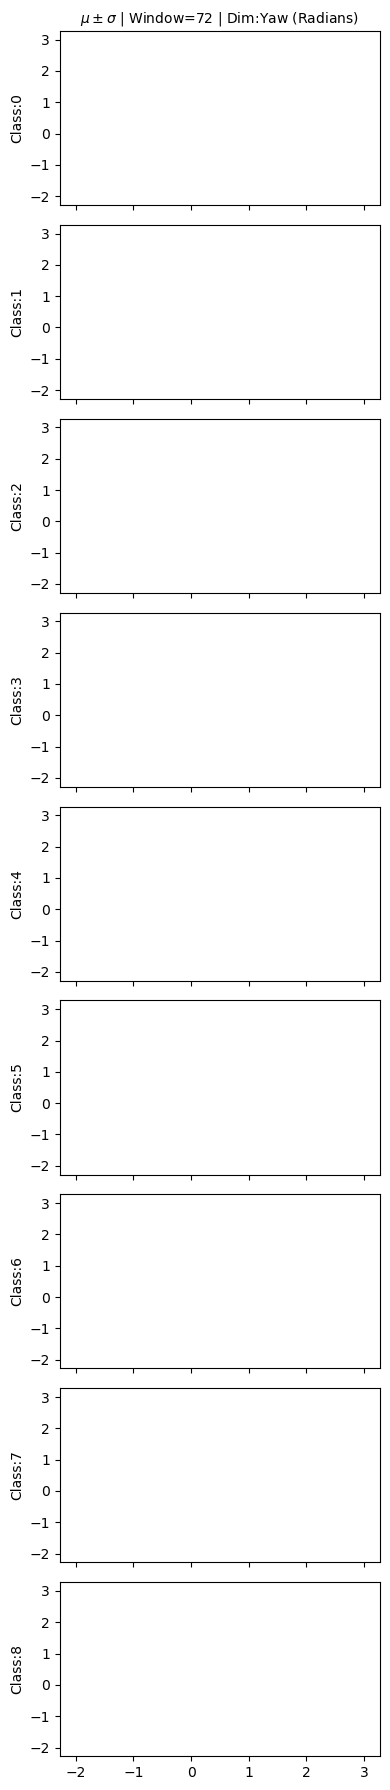

In [74]:
if(experiment_config.SHOW_PLOTS): plot_mean_std_ts(dataset_yaw, classes, \
                    rolling_window_size=ROLLING_WINDOW_PLOT, \
                    axes_labels=["Yaw (Radians)"], \
                    colors=['g'], \
                    figsize=(4,2), \
                    save_path=gen_path_plot("yaw_summary"))

## `Summary`

Until this point, the head movements are stored as in these data representations: 
- Quaternion (`dataset_quaternion`)
- Euler Angles (`dataset_euler`)
- Rotation around Z-axis (`dataset_yaw`)

## `NOTE:` REDEFINITION OF DATASETS
The dictionary is redefined now, since the datasets were properly loaded/created

In [75]:
NUM_CLASSES = num_classes # Global variable counting number of different classes in the dataset
# REDEFINE DICT WITH CORRESPONDING DATASETS
DICT_DATA_REPRESENTATIONS = {
    DataRepresentation.Quaternion:  dataset_quaternion,
    DataRepresentation.Euler:       dataset_euler,
    # DataRepresentation.Spherical:   dataset_spherical,
    DataRepresentation.Yaw:         dataset_yaw,
}

---
## Distance Metrics: Euclidean, Specific Euclidean, and DTW

** `NOTE >> ` Skip: This implementation was replaced by the optimized KNN from `sktime`**

In [76]:
### Test files that will be generated from the combination analysis
# Dictionary to know from where to load the CrossDistance matrix for a specific data representation, and specific distance metric
DICT_CDIST_FILES = { str(k):{} for k in DICT_DATA_REPRESENTATIONS.keys() } # Copy the keys from datarepresentations
for datarep,metric in combinations_to_analyze:
    filepath = gen_path_temp(f"{NOTEBOOK_SUBFOLDER_NAME}{experiment_config.PREFIX_CDIST_MATRIX}{str(datarep)}_{metric}", extension=".csv" )
    DICT_CDIST_FILES[str(datarep)][metric] = filepath # Add subkeys with metric, per each datarep
    print(filepath)
    
# Save the index in a file.
utils.create_json(DICT_CDIST_FILES, gen_path_temp(f"{NOTEBOOK_SUBFOLDER_NAME}_index{experiment_config.PREFIX_CDIST_MATRIX}", extension=".json" ))
print("Example for Quaternion Data Representation:")
print(DICT_CDIST_FILES[str(DataRepresentation.Euler)])

./temp/Tsinghua/1_DataRep_DistMetrics/cdistmat_quaternion_dtw.csv
./temp/Tsinghua/1_DataRep_DistMetrics/cdistmat_euler_dtw.csv
./temp/Tsinghua/1_DataRep_DistMetrics/cdistmat_yaw_dtw.csv
JSON file was created in ./temp/Tsinghua/1_DataRep_DistMetrics/_indexcdistmat_.json
Example for Quaternion Data Representation:
{'dtw': './temp/Tsinghua/1_DataRep_DistMetrics/cdistmat_euler_dtw.csv'}


In [77]:
print(">> FINISHED WITHOUT ERRORS!!")

>> FINISHED WITHOUT ERRORS!!
